In [1]:
import numpy as np

import matplotlib.pyplot as plt

import torch

from neuralop.models import FNO
from neuralop import Trainer, LpLoss
from neuralop.training import AdamW

from tqdm import tqdm

In [2]:
# %% Visualize some predictions
def plot_truth_vs_prediction(truth, prediction, x):
    plt.figure(figsize=(12, 5))
    plt.plot(x, truth, label='Truth', color='blue')
    plt.plot(x, prediction, label='Prediction', color='red', linestyle='--')
    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.title('Truth vs Prediction')
    plt.legend()
    plt.grid()
    plt.show()

# Viscous Burgers equation


\begin{align}
&\frac{\partial u}{\partial t} = \Delta u - u \frac{\partial u}{\partial x} 
 \\
&u(0,x)  = u_0(x)
\end{align}

(periodic boundary conditions). 

We aim to learn the solution/flow operator:

$$
\mathcal{S}: u_0 \mapsto u(T,x)
$$

The initial condition is drawn from 

$$
u_0 \sim \mathcal N(0, (-\Delta + I)^{-s})
$$

## Load and plot the data

In [3]:
folder = "data/burgers/"
from scipy.io import loadmat
data = loadmat(folder + "burgers_data_R10.mat")

print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'a', 'a_smooth', 'a_smooth_x', 'a_x', 'u'])


In [4]:
u0 = data['a']  # shape (N_samples, N_space)
uT  = data['u']  # shape (N_samples, N_space)

In [5]:
x = np.linspace(0, 1, u0.shape[1])
downsample_factor = 2**6
x = x[::downsample_factor]
u0 = u0[:, ::downsample_factor]
uT = uT[:, ::downsample_factor]

In [6]:
N = u0.shape[0]
n_train = int(0.8 * N)
u0_train = u0[:n_train,:]
uT_train = uT[:n_train,:]
u0_test = u0[n_train:,:]
uT_test = uT[n_train:,:]
print(u0_train.shape, uT_train.shape, u0_test.shape, uT_test.shape)

(1638, 128) (1638, 128) (410, 128) (410, 128)


## Input/output plot

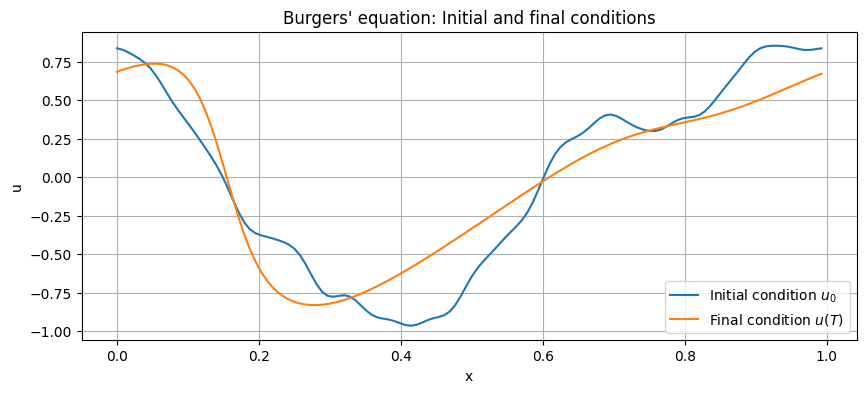

In [7]:
# Plot a an initial and final condition from the dataset
idx = 0
plt.figure(figsize=(10,4))
plt.plot(x, u0[idx], label='Initial condition $u_0$')
plt.plot(x, uT[idx], label='Final condition $u(T)$')
plt.xlabel('x')
plt.ylabel('u')
plt.title('Burgers\' equation: Initial and final conditions')
plt.legend()
plt.grid()
plt.show()

# FNO

## Data preparation

In [8]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert to tensors
u0_train = torch.tensor(u0_train, dtype=torch.float32)
uT_train = torch.tensor(uT_train, dtype=torch.float32)
u0_test  = torch.tensor(u0_test,  dtype=torch.float32)
uT_test  = torch.tensor(uT_test,  dtype=torch.float32)

# Add channel dimension: (N, 1, X)
u0_train = u0_train.unsqueeze(1)
uT_train = uT_train.unsqueeze(1)
u0_test  = u0_test.unsqueeze(1)
uT_test  = uT_test.unsqueeze(1)

print(u0_train.shape, uT_train.shape)

torch.Size([1638, 1, 128]) torch.Size([1638, 1, 128])


In [9]:
# Optional: Normalize the data

def normalize(tensor, mean, std, jitter = 1e-6):
    return (tensor - mean) / (std + jitter)

def denormalize(tensor, mean, std, jitter = 1e-6):
    return tensor * (std + jitter) + mean


mean_u0 = u0_train.mean()
std_u0  = u0_train.std()

mean_uT = uT_train.mean()
std_uT  = uT_train.std()

u0_train_norm = normalize(u0_train, mean_u0, std_u0)
uT_train_norm= normalize(uT_train, mean_uT, std_uT)
u0_test_norm  = normalize(u0_test,  mean_u0, std_u0)
uT_test_norm  = normalize(uT_test,  mean_uT, std_uT)


In [10]:
train_dataset = TensorDataset(u0_train_norm, uT_train_norm)
test_dataset  = TensorDataset(u0_test_norm, uT_test_norm)

# Create DataLoaders
batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
)

# Define the model

In [11]:
import torch
from neuralop.models import FNO

device = "cuda" if torch.cuda.is_available() else "cpu"

model = FNO(
    n_modes=(8,),          # increase to 16/24/32 if X is large
    hidden_channels=32,
    in_channels=1,
    out_channels=1,
    n_layers=3,
).to(device)

print("Device:", device)
print(model)

Device: cpu
FNO(
  (positional_embedding): GridEmbeddingND()
  (fno_blocks): FNOBlocks(
    (convs): ModuleList(
      (0-2): 3 x SpectralConv(
        (weight): DenseTensor(shape=torch.Size([32, 32, 5]), rank=None)
      )
    )
    (fno_skips): ModuleList(
      (0-2): 3 x Flattened1dConv(
        (conv): Conv1d(32, 32, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
    (channel_mlp): ModuleList(
      (0-2): 3 x ChannelMLP(
        (fcs): ModuleList(
          (0): Conv1d(32, 16, kernel_size=(1,), stride=(1,))
          (1): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
        )
      )
    )
    (channel_mlp_skips): ModuleList(
      (0-2): 3 x SoftGating()
    )
  )
  (lifting): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(2, 64, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
    )
  )
  (projection): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64, 1, kerne

## Define the training loop

In [12]:
import os
import torch
import matplotlib.pyplot as plt

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2, weight_decay=1e-5)

def run_epoch(model, loader, train: bool):
    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    n_samples = 0

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        if train:
            optimizer.zero_grad(set_to_none=True)

        with torch.set_grad_enabled(train):
            y_hat = model(x)
            loss = loss_fn(y_hat, y)

            if train:
                loss.backward()
                optimizer.step()

        bs = x.shape[0]
        total_loss += loss.item() * bs
        n_samples += bs

    return total_loss / max(n_samples, 1)

epochs = 50

best_test = float("inf")
train_losses, test_losses = [], []

for epoch in range(1, epochs + 1):
    train_loss = run_epoch(model, train_loader, train=True)
    test_loss  = run_epoch(model, test_loader,  train=False)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    if test_loss < best_test:
        best_test = test_loss

    if epoch == 1 or epoch % 1 == 0:
        print(f"Epoch {epoch:4d} | train {train_loss:.6e} | test {test_loss:.6e} | best {best_test:.6e}")

Epoch    1 | train 7.594387e-02 | test 4.465954e-03 | best 4.465954e-03
Epoch    2 | train 2.643202e-03 | test 2.248436e-03 | best 2.248436e-03
Epoch    3 | train 1.223146e-03 | test 8.970434e-04 | best 8.970434e-04
Epoch    4 | train 8.068251e-04 | test 6.815642e-04 | best 6.815642e-04
Epoch    5 | train 1.968204e-03 | test 1.982233e-03 | best 6.815642e-04
Epoch    6 | train 1.132737e-03 | test 6.590593e-04 | best 6.590593e-04
Epoch    7 | train 3.006085e-04 | test 2.445318e-04 | best 2.445318e-04
Epoch    8 | train 4.751083e-04 | test 2.860223e-03 | best 2.445318e-04
Epoch    9 | train 7.571412e-04 | test 5.781239e-04 | best 2.445318e-04
Epoch   10 | train 2.560403e-03 | test 8.167969e-04 | best 2.445318e-04
Epoch   11 | train 7.371376e-04 | test 4.168469e-04 | best 2.445318e-04
Epoch   12 | train 2.076450e-04 | test 1.644584e-04 | best 1.644584e-04
Epoch   13 | train 2.071825e-04 | test 5.760713e-04 | best 1.644584e-04
Epoch   14 | train 4.196067e-04 | test 3.228931e-04 | best 1.644

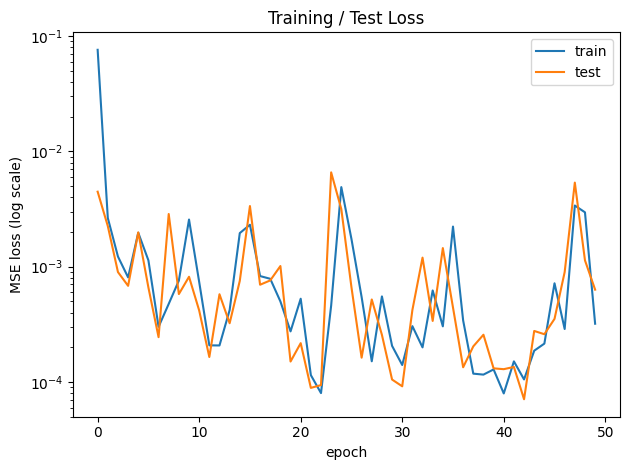

In [13]:
# --- Plot losses ---
plt.figure()
plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("MSE loss (log scale)")
plt.title("Training / Test Loss")
plt.legend()
plt.tight_layout()
plt.show()

# Predict 

In [14]:
pred_test = model(u0_test_norm.to(device)).detach().cpu()
pred_test_denorm = denormalize(pred_test, mean_uT, std_uT).squeeze()
error = torch.norm(uT_test.squeeze() - pred_test_denorm, dim=1) / torch.norm(uT_test.squeeze(), dim=1)
print(f"Average relative L2 error on test set: {error.mean().item():.6e}")

Average relative L2 error on test set: 2.703197e-02


## Plot an example

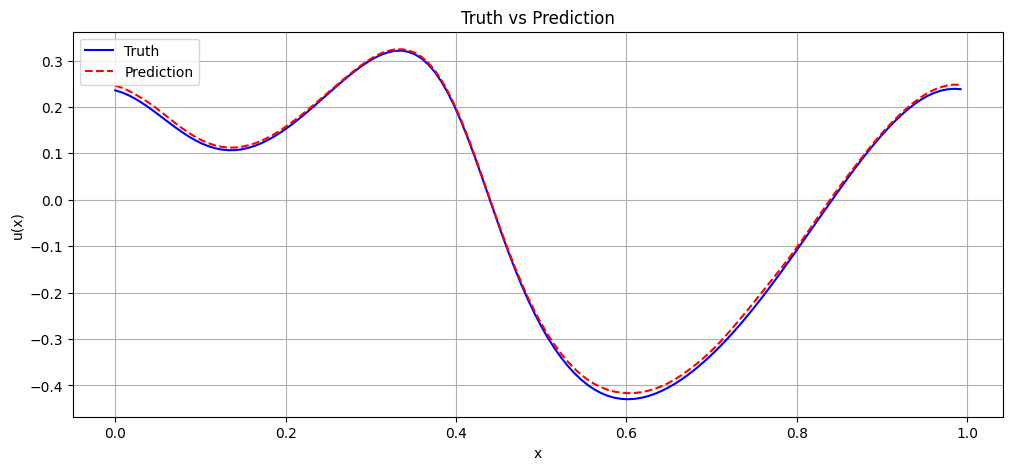

In [15]:
pred = pred_test_denorm[0]
truth = uT_test.squeeze()[0]
plot_truth_vs_prediction(truth.numpy(), pred.numpy(), x)